In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Used for nicer plots
import os

# --- 1. Define Constants and Load Data ---
# (Using the BASE_PATH you defined in your first cell)
TRAIN_CSV_PATH = os.path.join(BASE_PATH, 'train.csv')

print(f"Loading data from {TRAIN_CSV_PATH}...")
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    print("Data loaded successfully.")
    
    # --- 2. Initial Inspection ---
    print("\n" + "="*60)
    print("--- DataFrame Info ---")
    train_df.info()
    
    print("\n" + "="*60)
    print("--- Data Head (First 5 Rows) ---")
    print(train_df.head())
    print("="*60)

except FileNotFoundError:
    print(f"Error: Could not find {TRAIN_CSV_PATH}")
    print("Please ensure your BASE_PATH variable is set correctly.")
except Exception as e:
    print(f"An error occurred: {e}")

Loading data from /kaggle/input/rsna-intracranial-aneurysm-detection/train.csv...
Data loaded successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348 entries, 0 to 4347
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   SeriesInstanceUID                           4348 non-null   object
 1   PatientAge                                  4348 non-null   int64 
 2   PatientSex                                  4348 non-null   object
 3   Modality                                    4348 non-null   object
 4   Left Infraclinoid Internal Carotid Artery   4348 non-null   int64 
 5   Right Infraclinoid Internal Carotid Artery  4348 non-null   int64 
 6   Left Supraclinoid Internal Carotid Artery   4348 non-null   int64 
 7   Right Supraclinoid Internal Carotid Artery  4348 non-null   int64 
 8   Left Middle Cerebral Artery         


--- EDA: Analyzing Aneurysm Location Frequencies ---
Found 13 location columns to analyze.

--- Most Common Aneurysm Location ---
Location: Anterior Communicating Artery
Count:    363 cases

Full Location Counts:
Anterior Communicating Artery                 363
Left Supraclinoid Internal Carotid Artery     330
Right Middle Cerebral Artery                  294
Right Supraclinoid Internal Carotid Artery    278
Left Middle Cerebral Artery                   219
Other Posterior Circulation                   113
Basilar Tip                                   110
Right Posterior Communicating Artery          101
Right Infraclinoid Internal Carotid Artery     98
Left Posterior Communicating Artery            86
Left Infraclinoid Internal Carotid Artery      78
Right Anterior Cerebral Artery                 56
Left Anterior Cerebral Artery                  46
dtype: int64

--- Plotting Aneurysm Location Frequencies ---


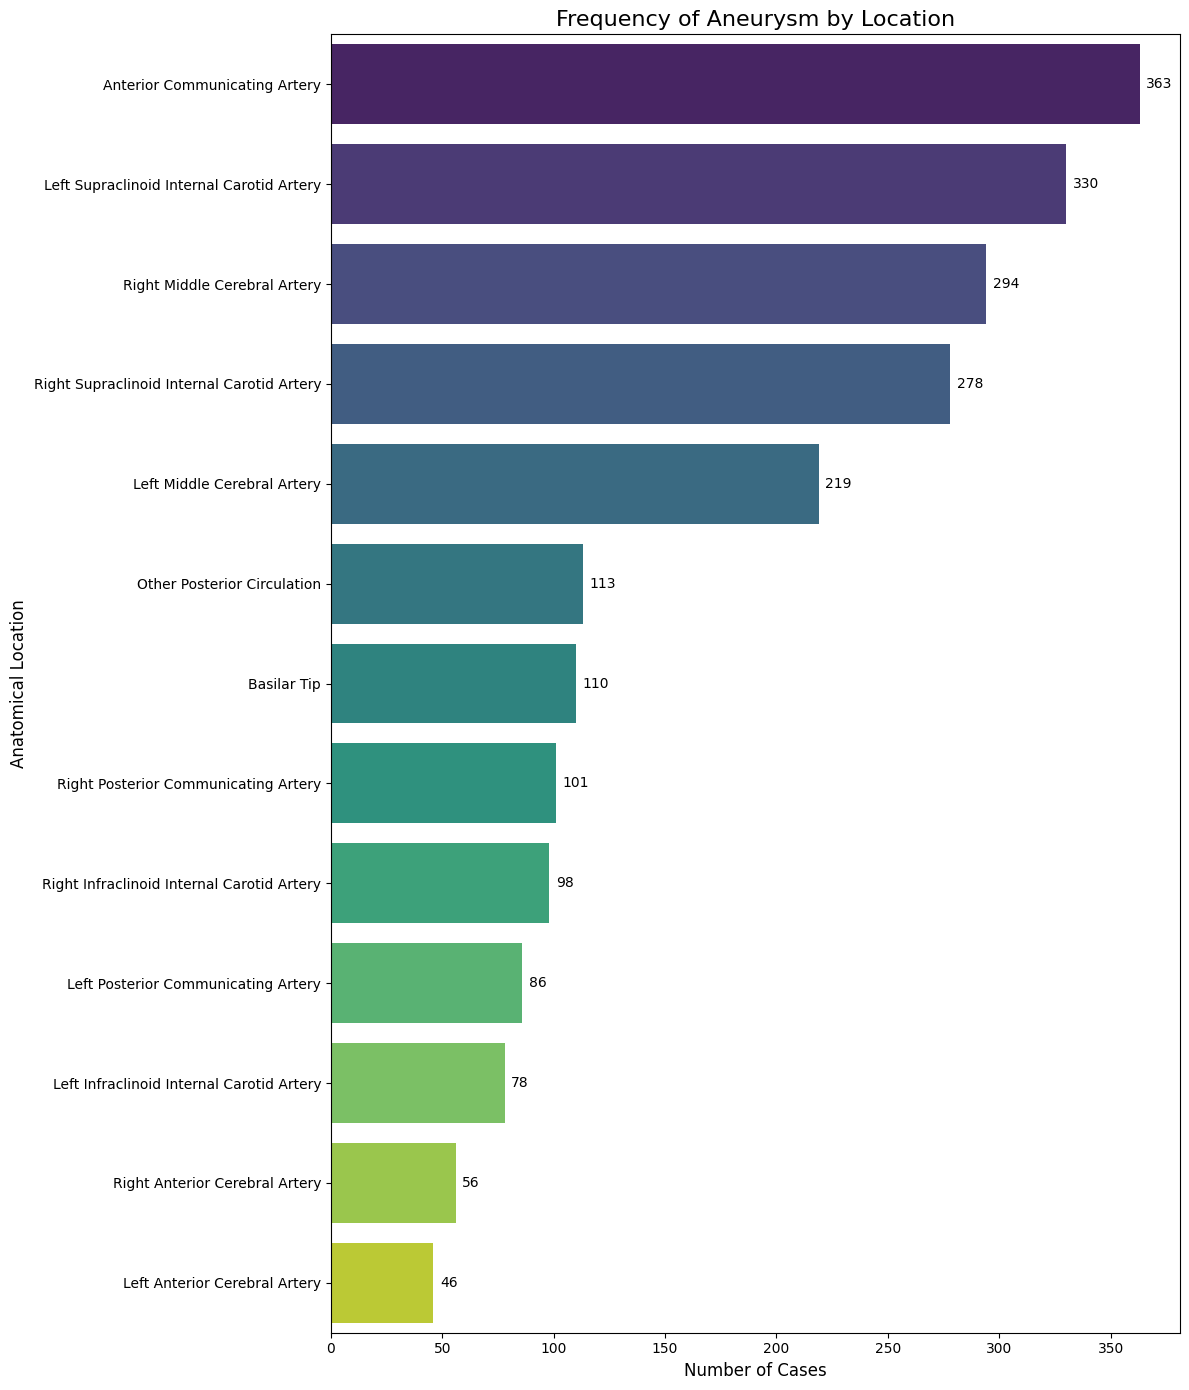

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("--- EDA: Analyzing Aneurysm Location Frequencies ---")

# 1. Define the metadata columns to *exclude*
# (Based on your .info() output)
NON_LOCATION_COLS = ['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality', 'Aneurysm Present']

# 2. Get a list of all columns that are *only* locations
location_cols = [col for col in train_df.columns if col not in NON_LOCATION_COLS]
print(f"Found {len(location_cols)} location columns to analyze.")

# 3. Sum the occurrences for each location
# This adds up all the '1's in each location column
location_counts = train_df[location_cols].sum()

# 4. Sort the results to see the most common ones at the top
location_counts = location_counts.sort_values(ascending=False)

# 5. Find and print the single most common location
most_common_location = location_counts.idxmax()
most_common_count = location_counts.max()

print("\n" + "="*60)
print("--- Most Common Aneurysm Location ---")
print(f"Location: {most_common_location}")
print(f"Count:    {most_common_count} cases")
print("="*60)

# Display the counts
print("\nFull Location Counts:")
print(location_counts)
print("="*60)

# --- NEW: Plotting the Bar Graph ---
print("\n--- Plotting Aneurysm Location Frequencies ---")

# Set a good size for the plot
# We make it taller than it is wide to fit all the labels
plt.figure(figsize=(12, 14))

# Use Seaborn for a nicer-looking horizontal bar plot
# We plot the counts on the x-axis and the location names (index) on the y-axis
sns.barplot(
    x=location_counts.values, 
    y=location_counts.index,
    palette='viridis' # 'viridis' is a nice, high-contrast color palette
)

plt.title('Frequency of Aneurysm by Location', fontsize=16)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Anatomical Location', fontsize=12)

# Add the data labels (the counts) to the end of each bar for clarity
for index, value in enumerate(location_counts.values):
    # Place text just to the right of the bar
    plt.text(value + 3, index, str(value), va='center') 

plt.tight_layout() # Adjusts plot to prevent labels from being cut off
plt.show()

Found 130 MRA aneurysms in 'Left Supraclinoid Internal Carotid Artery'


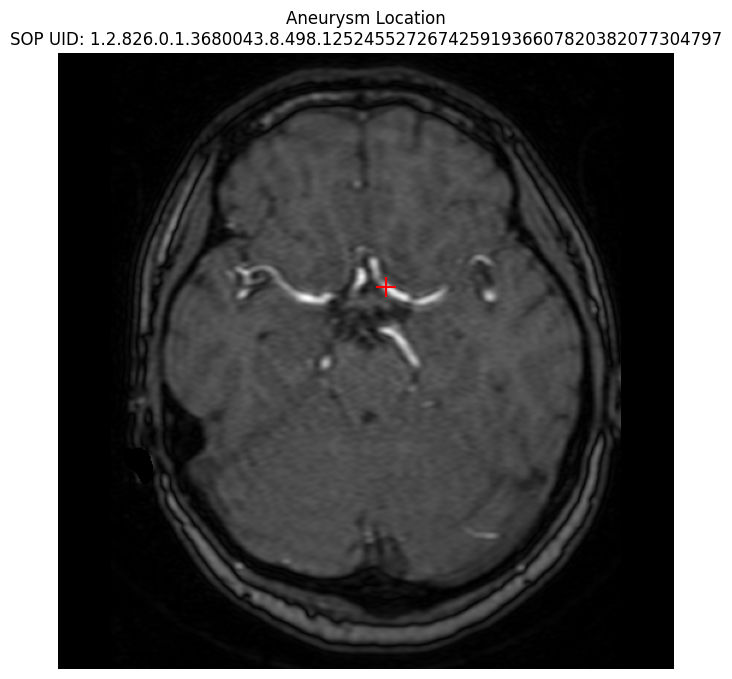

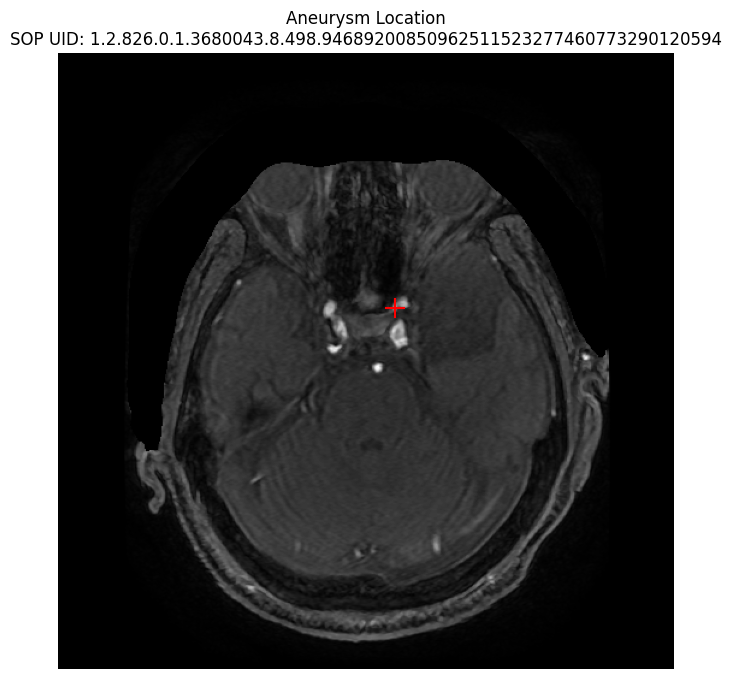

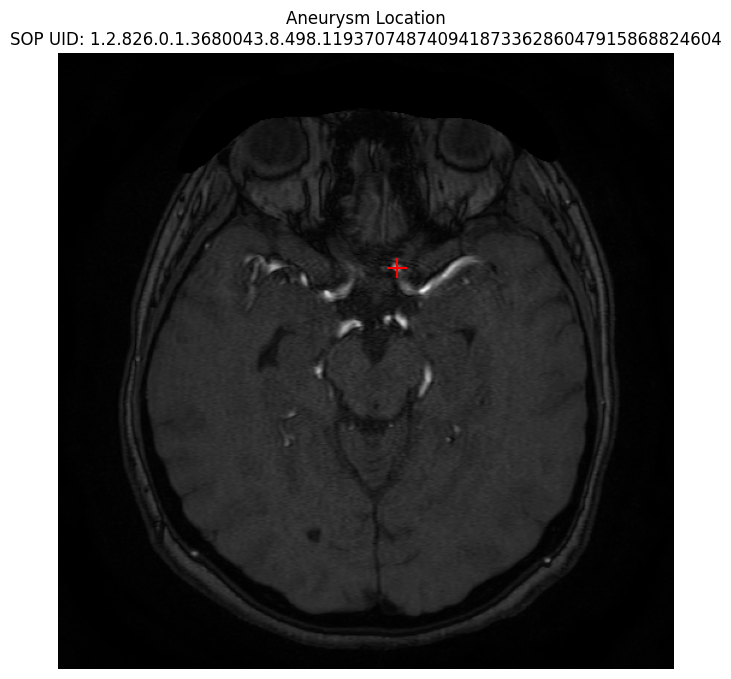

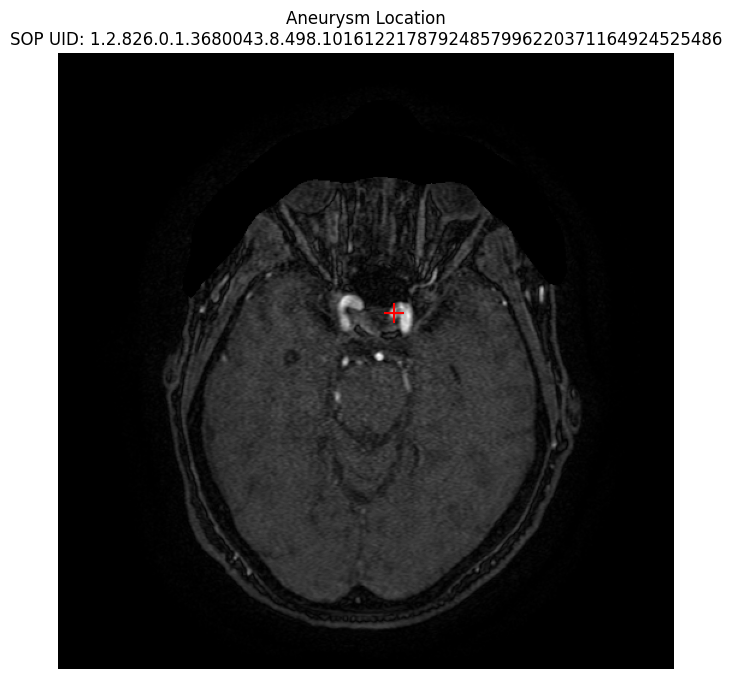

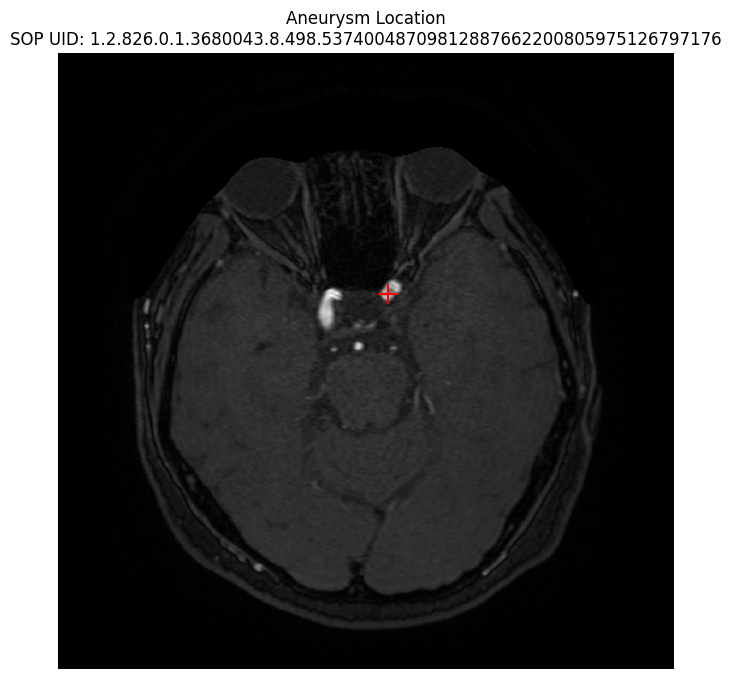

In [1]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import ast
import os

# Define the base path for the competition data
BASE_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/'

# --- 1. Load Data ---
# The file paths are simple and direct in the Kaggle environment
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
localizers_df = pd.read_csv(os.path.join(BASE_PATH, 'train_localizers.csv'))

# --- 2. Filter for Target Aneurysms ---
# Get the list of SeriesInstanceUIDs for MRA scans from train.csv
mra_scans_ids = train_df[train_df['Modality'] == 'MRA']['SeriesInstanceUID'].unique()

# Filter localizers_df for the specific region
target_region = 'Left Supraclinoid Internal Carotid Artery'
region_filtered_df = localizers_df[localizers_df['location'] == target_region]

# Combine the filters to get our final list of target aneurysms
final_df = region_filtered_df[region_filtered_df['SeriesInstanceUID'].isin(mra_scans_ids)]
print(f"Found {len(final_df)} MRA aneurysms in '{target_region}'")
print("="*60)

# --- 3. Visualize the First 5 Aneurysms ---
instances_to_visualize = final_df.head(5)

for index, row in instances_to_visualize.iterrows():
    series_uid = row['SeriesInstanceUID']
    sop_uid = row['SOPInstanceUID']
    coords = ast.literal_eval(row['coordinates'])
    x_coord = coords['x']
    y_coord = coords['y']
    
    # Construct the direct file path
    file_path = os.path.join(BASE_PATH, 'series', series_uid, f'{sop_uid}.dcm')
    
    try:
        dicom_image = pydicom.dcmread(file_path)
        pixel_data = dicom_image.pixel_array
        
        # Select the correct 2D slice from the 3D data stack
        if pixel_data.ndim == 3:
            if 'z' in coords:
                slice_index = int(round(coords['z']))
            else:
                slice_index = pixel_data.shape[0] // 2
            image_to_display = pixel_data[slice_index, :, :]
        else:
            image_to_display = pixel_data

        # Plotting
        plt.figure(figsize=(8, 8))
        plt.imshow(image_to_display, cmap=plt.cm.gray)
        plt.scatter(x_coord, y_coord, s=200, c='red', marker='+')
        plt.title(f"Aneurysm Location\nSOP UID: {sop_uid}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {sop_uid}: {e}")

In [4]:
import os

# Get the list of unique series IDs from our filtered data
series_to_count = final_df['SeriesInstanceUID'].unique()

series_file_counts = {}

# Loop and count the files in each directory
for series_uid in series_to_count:
    directory_path = os.path.join(BASE_PATH, 'series', series_uid)
    
    # os.listdir() gives a list of all files in a directory
    # len() gives us the count
    if os.path.exists(directory_path):
        num_files = len(os.listdir(directory_path))
        series_file_counts[series_uid] = num_files

# Display the results
results_df = pd.DataFrame(list(series_file_counts.items()), columns=['SeriesInstanceUID', 'FileCount'])
print("File Counts for Each Series:")
print(results_df.head())

File Counts for Each Series:
                                   SeriesInstanceUID  FileCount
0  1.2.826.0.1.3680043.8.498.10134365079002163886...          1
1  1.2.826.0.1.3680043.8.498.10152316071300066886...        120
2  1.2.826.0.1.3680043.8.498.10212302880573111557...        200
3  1.2.826.0.1.3680043.8.498.10281576424046867541...        202
4  1.2.826.0.1.3680043.8.498.10311779504410035494...        108


In [5]:
# This assumes your DataFrame is named results_df
# The index=False argument prevents pandas from writing the DataFrame index as a column
results_df.to_csv('series_file_counts.csv', index=False)

print("Successfully saved the results to series_file_counts.csv")

Successfully saved the results to series_file_counts.csv


In [6]:
import pandas as pd
import os

# Define the base path for the competition data
BASE_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/'

try:
    # --- Step 1: Load and Filter the File Counts ---
    counts_df = pd.read_csv('series_file_counts.csv')
    filtered_counts_df = counts_df[counts_df['FileCount'] > 1].copy()
    print(f"Removed single-instance series. Analyzing {len(filtered_counts_df)} series.")

    # --- Step 2: Load the Aneurysm Location Data ---
    localizers_df = pd.read_csv(os.path.join(BASE_PATH, 'train_localizers.csv'))

    # --- Step 3: Merge DataFrames ---
    merged_df = pd.merge(
        filtered_counts_df,
        localizers_df[['SeriesInstanceUID', 'SOPInstanceUID']],
        on='SeriesInstanceUID'
    )

    # --- Step 4: Loop, Find Index, and Normalize ---
    results_data = []
    print("\nCalculating normalized aneurysm positions...")

    for index, row in merged_df.iterrows():
        series_uid = row['SeriesInstanceUID']
        sop_uid = row['SOPInstanceUID']
        file_count = row['FileCount']
        
        aneurysm_filename = f'{sop_uid}.dcm'
        directory_path = os.path.join(BASE_PATH, 'series', series_uid)

        try:
            all_files = sorted(os.listdir(directory_path))
            aneurysm_index = all_files.index(aneurysm_filename)
            normalized_position = (aneurysm_index + 1) / file_count
            
            results_data.append({
                'SeriesInstanceUID': series_uid,
                'Aneurysm_SOPInstanceUID': sop_uid,
                'Aneurysm_Index': aneurysm_index,
                'Total_Frames': file_count,
                'Normalized_Position': normalized_position
            })

        except FileNotFoundError:
            print(f"Warning: Directory not found for series {series_uid}")
        except ValueError:
            print(f"Warning: Aneurysm file {aneurysm_filename} not found in series {series_uid}")

    # --- Step 5: Create and Display the Final DataFrame ---
    final_results_df = pd.DataFrame(results_data)
    final_results_df.to_csv('aneurysm_normalized_positions.csv', index=False)

    print("\n" + "="*60)
    print("Calculation Complete. Results saved to 'aneurysm_normalized_positions.csv'")
    print("Here are the first 5 rows of the results:")
    print(final_results_df.head())

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure 'series_file_counts.csv' exists by running Step 1.")
    print(f"Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Removed single-instance series. Analyzing 102 series.

Calculating normalized aneurysm positions...

Calculation Complete. Results saved to 'aneurysm_normalized_positions.csv'
Here are the first 5 rows of the results:
                                   SeriesInstanceUID  \
0  1.2.826.0.1.3680043.8.498.10152316071300066886...   
1  1.2.826.0.1.3680043.8.498.10212302880573111557...   
2  1.2.826.0.1.3680043.8.498.10281576424046867541...   
3  1.2.826.0.1.3680043.8.498.10311779504410035494...   
4  1.2.826.0.1.3680043.8.498.10320104854524208588...   

                             Aneurysm_SOPInstanceUID  Aneurysm_Index  \
0  1.2.826.0.1.3680043.8.498.94689200850962511523...             110   
1  1.2.826.0.1.3680043.8.498.11937074874094187336...              40   
2  1.2.826.0.1.3680043.8.498.10161221787924857996...               4   
3  1.2.826.0.1.3680043.8.498.53740048709812887662...              73   
4  1.2.826.0.1.3680043.8.498.97921890635037721236...             188   

   Total_Fra

Finding 'normal' MRA scans for the region: Left Supraclinoid Internal Carotid Artery...
Found 1129 'normal' MRA series for this region.

Visualizing a 5-frame window around the 48% position...


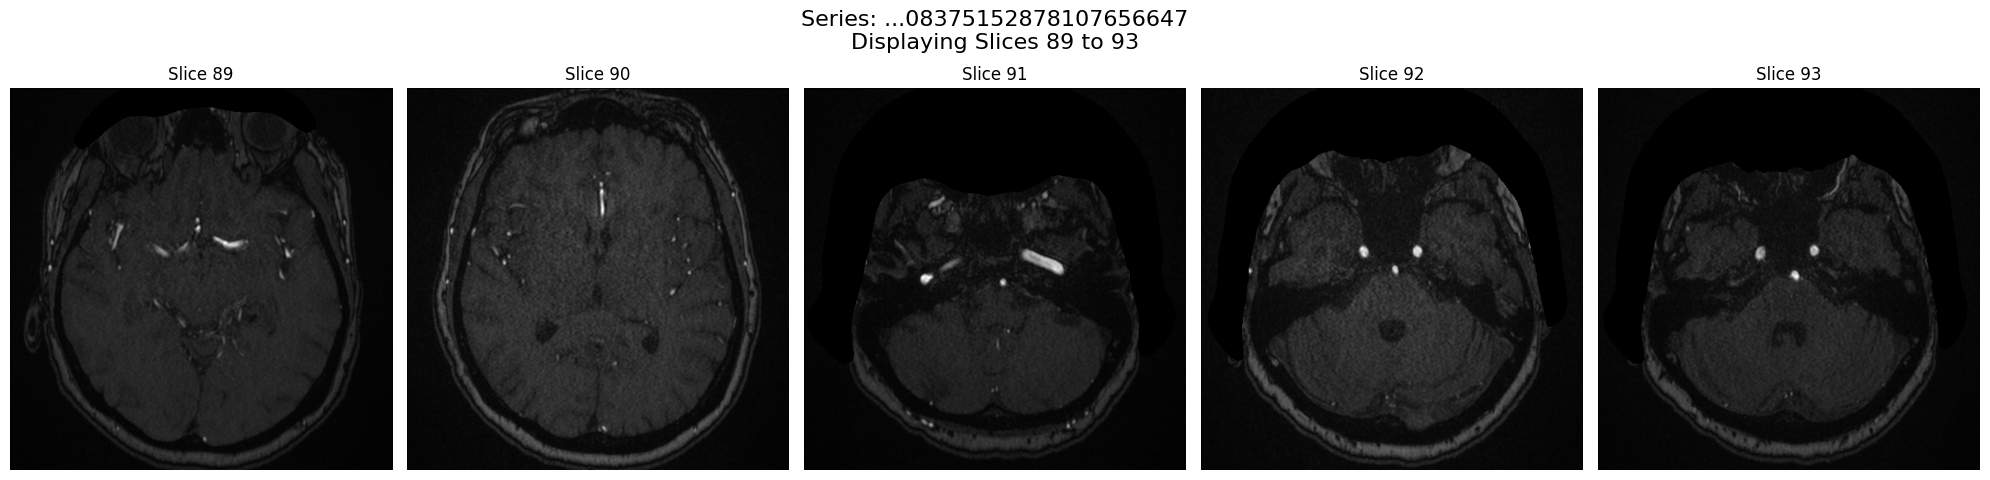

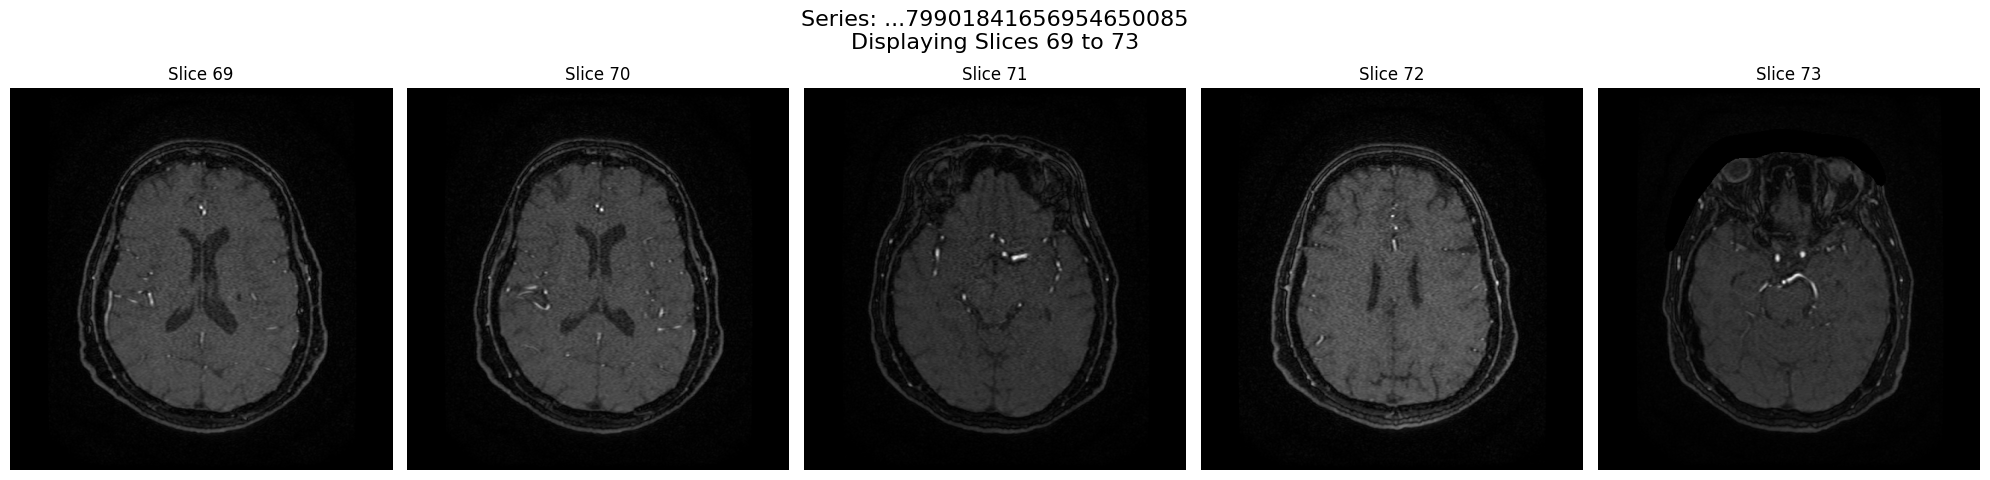

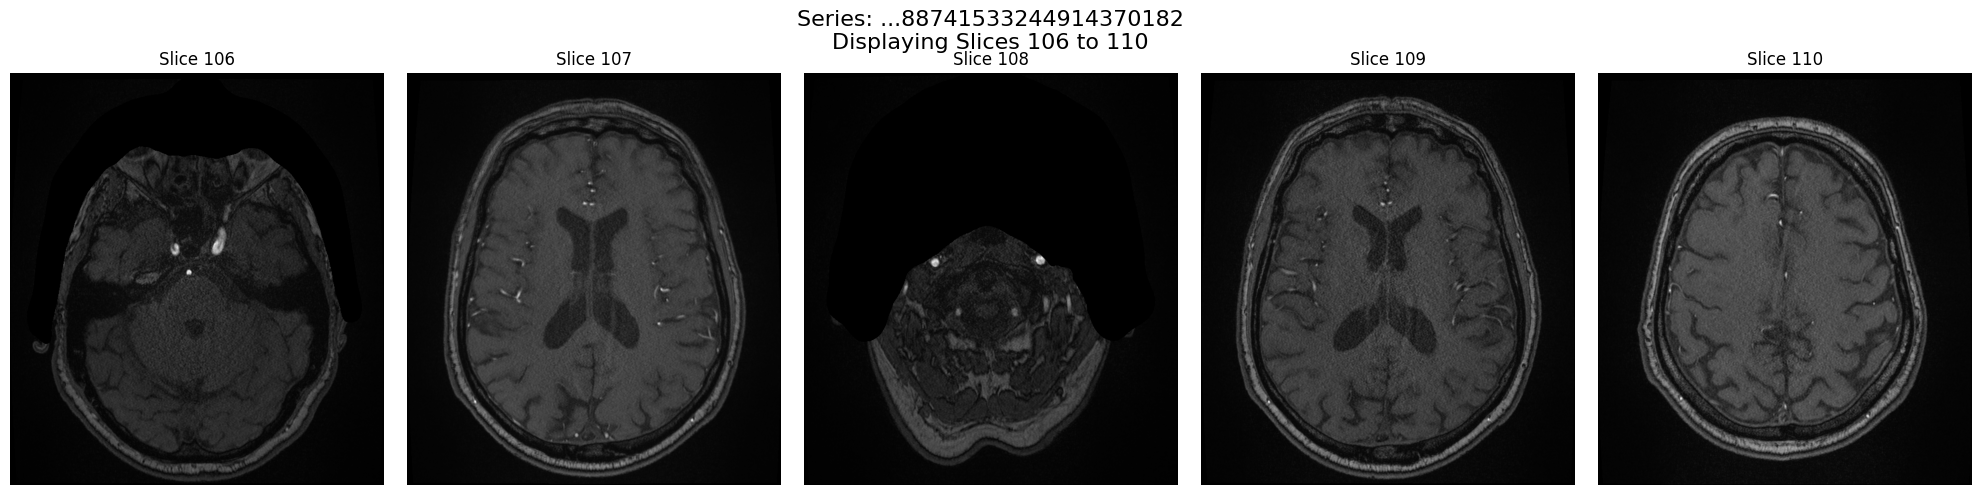

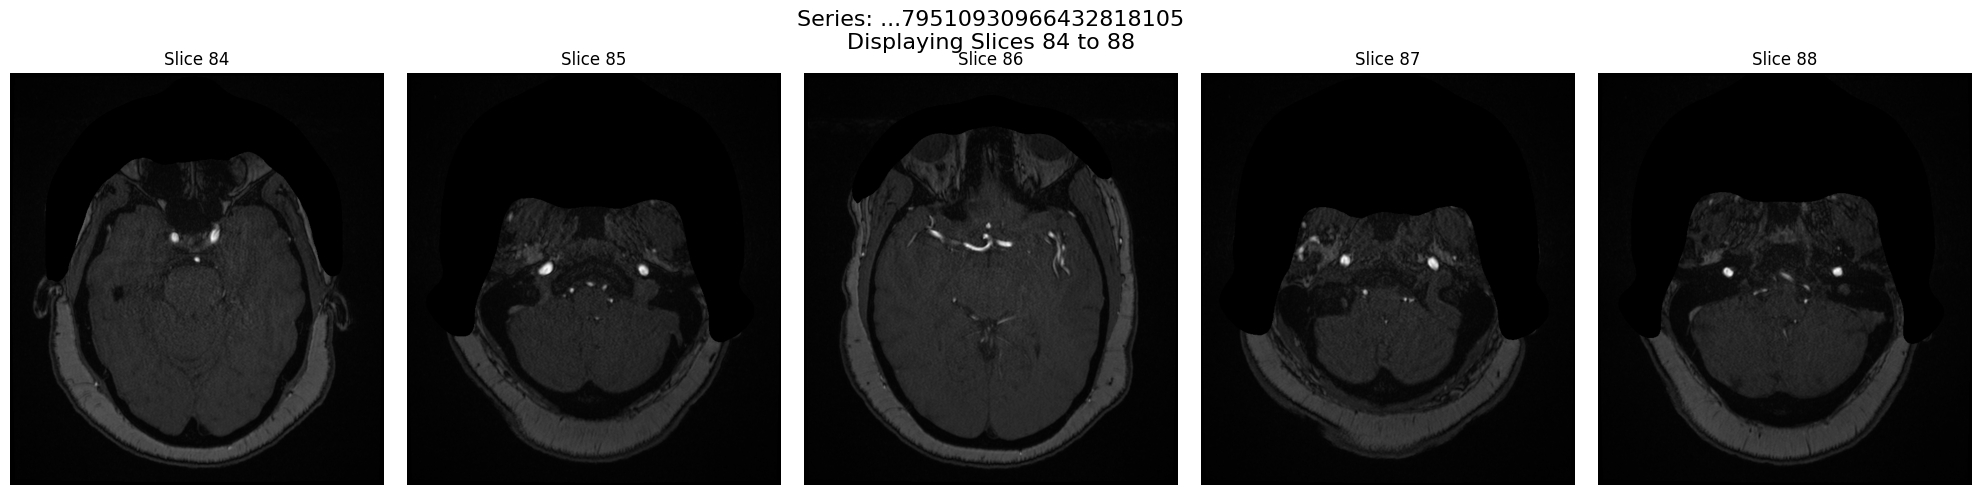

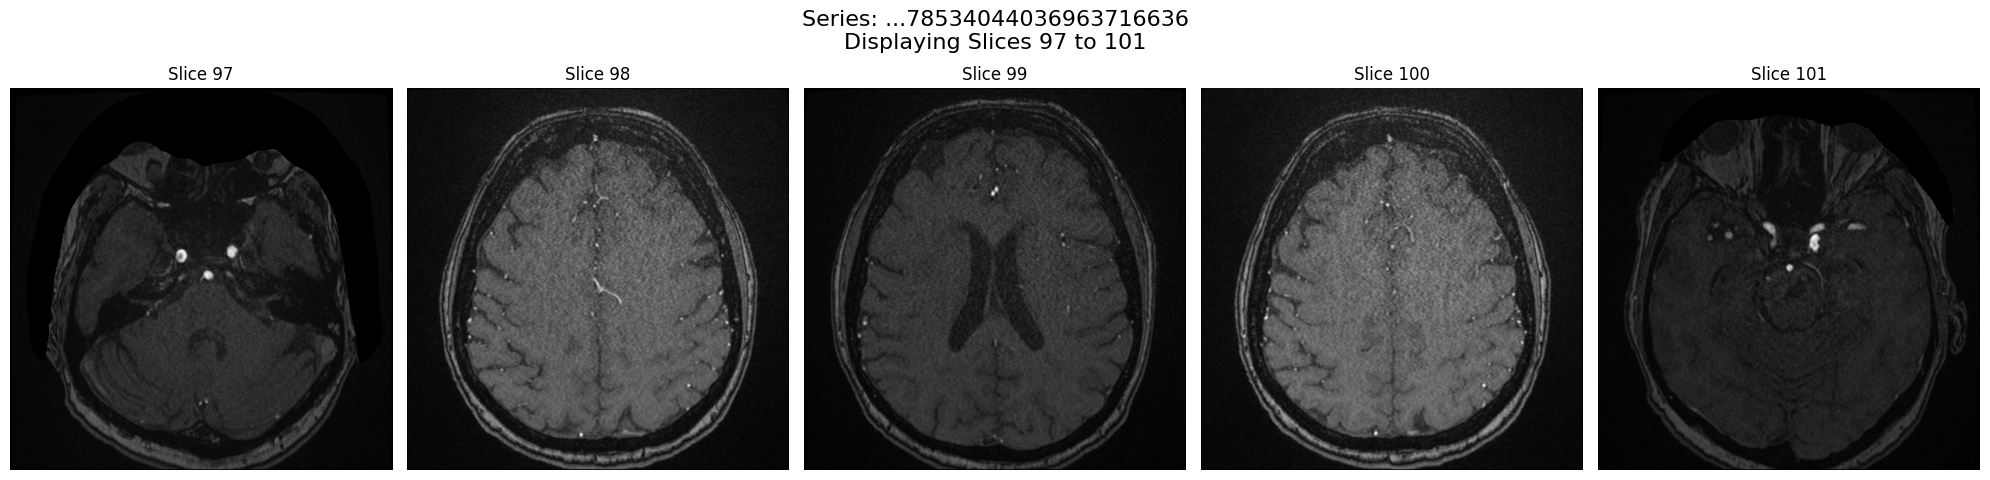

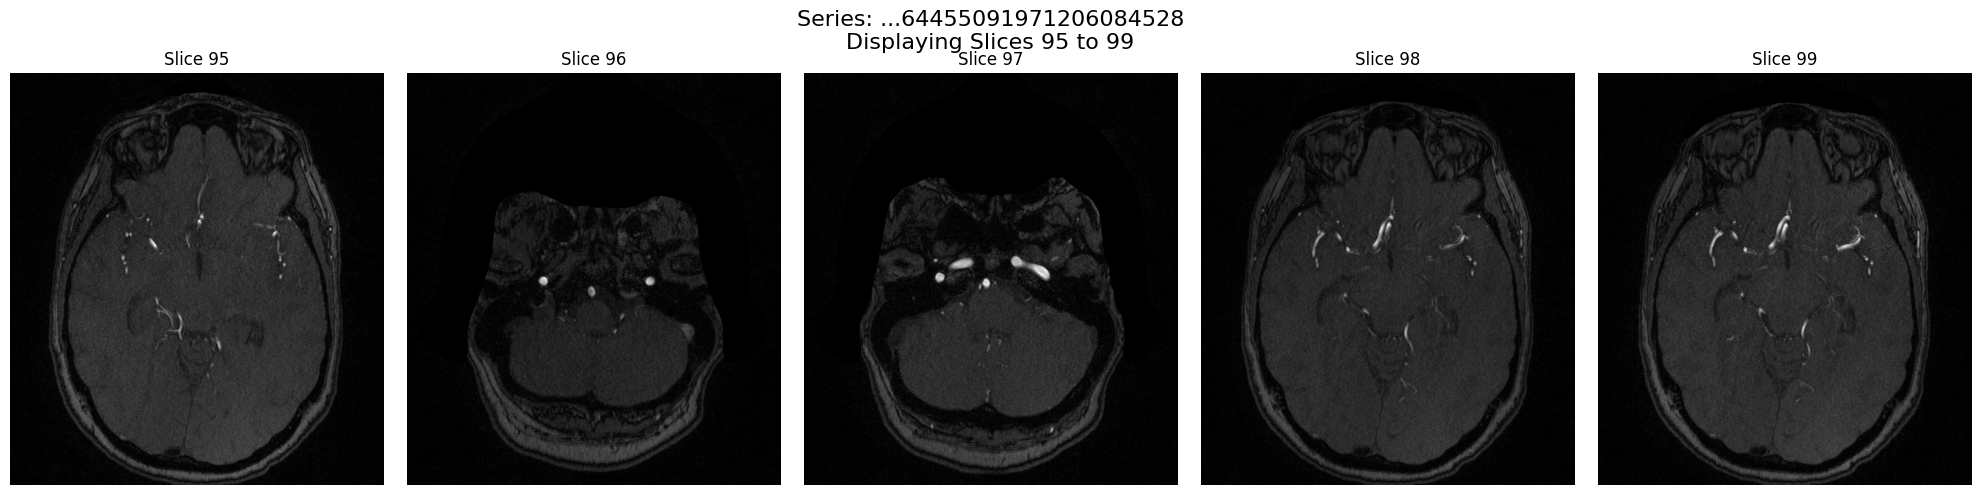

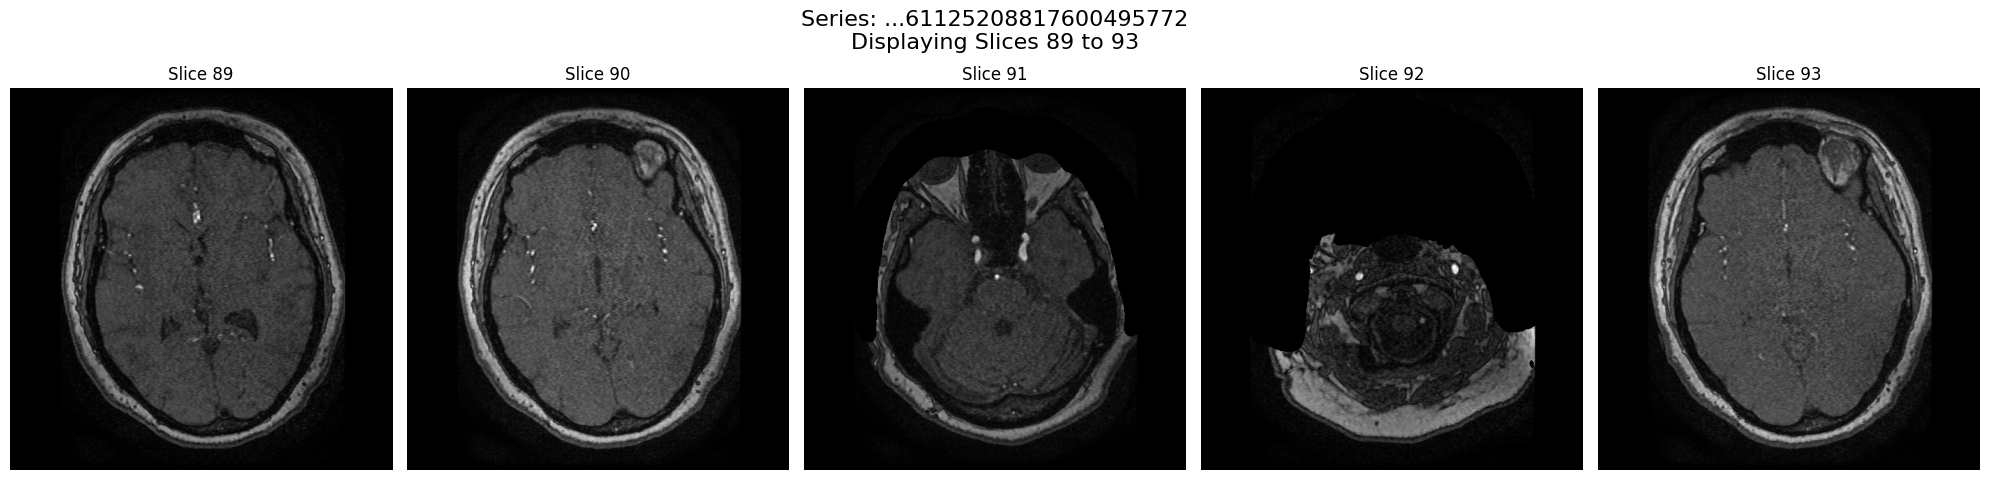

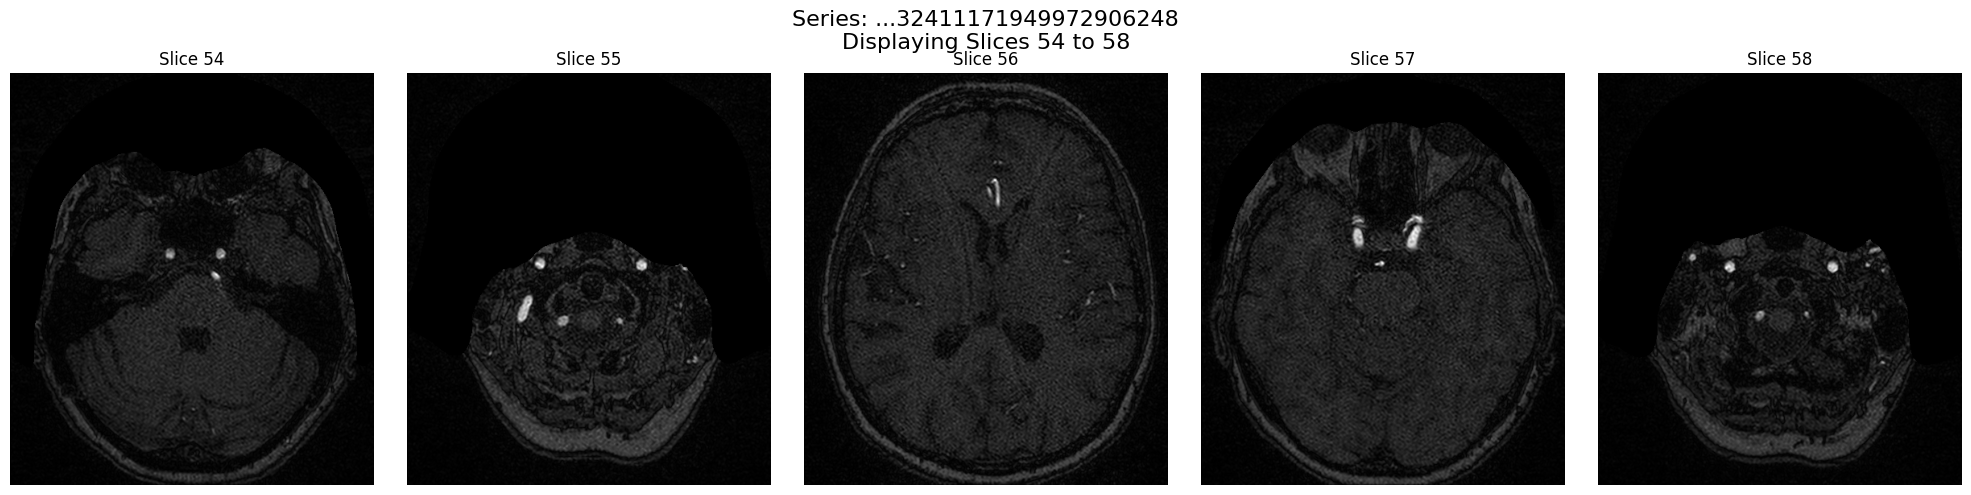

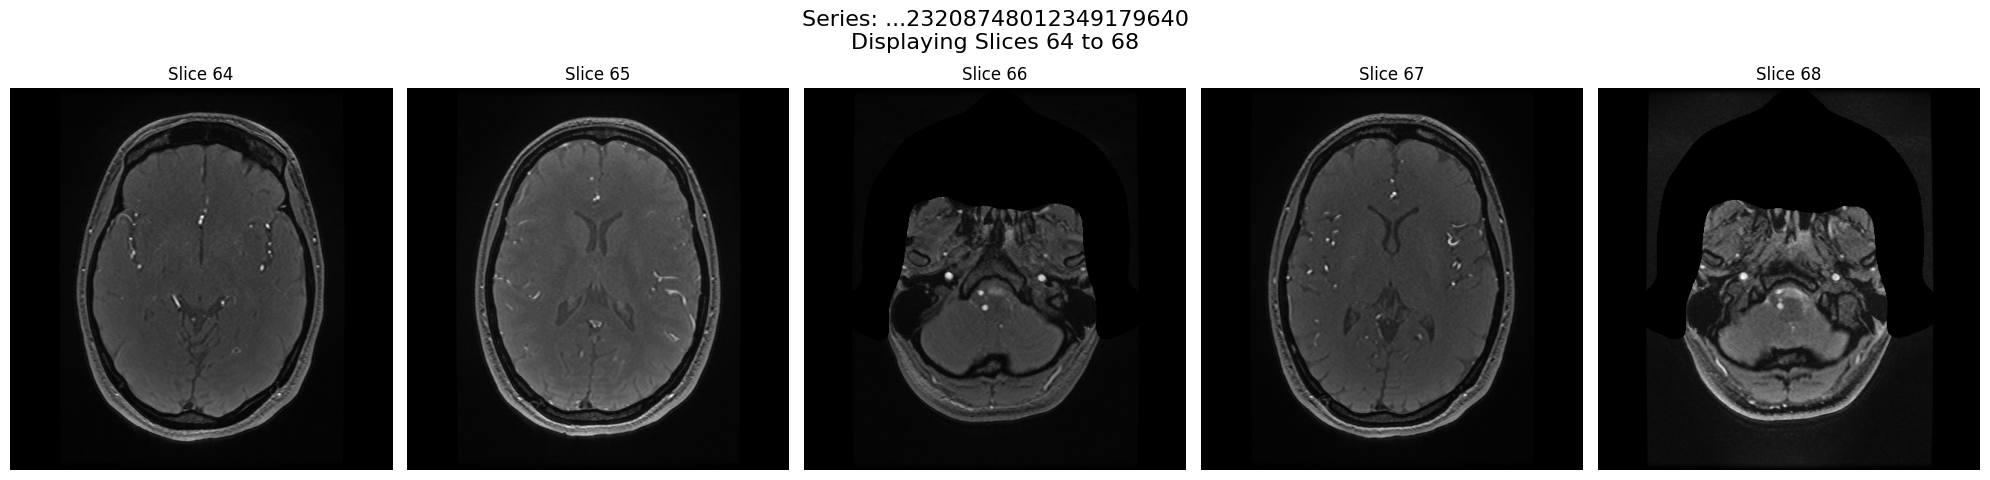

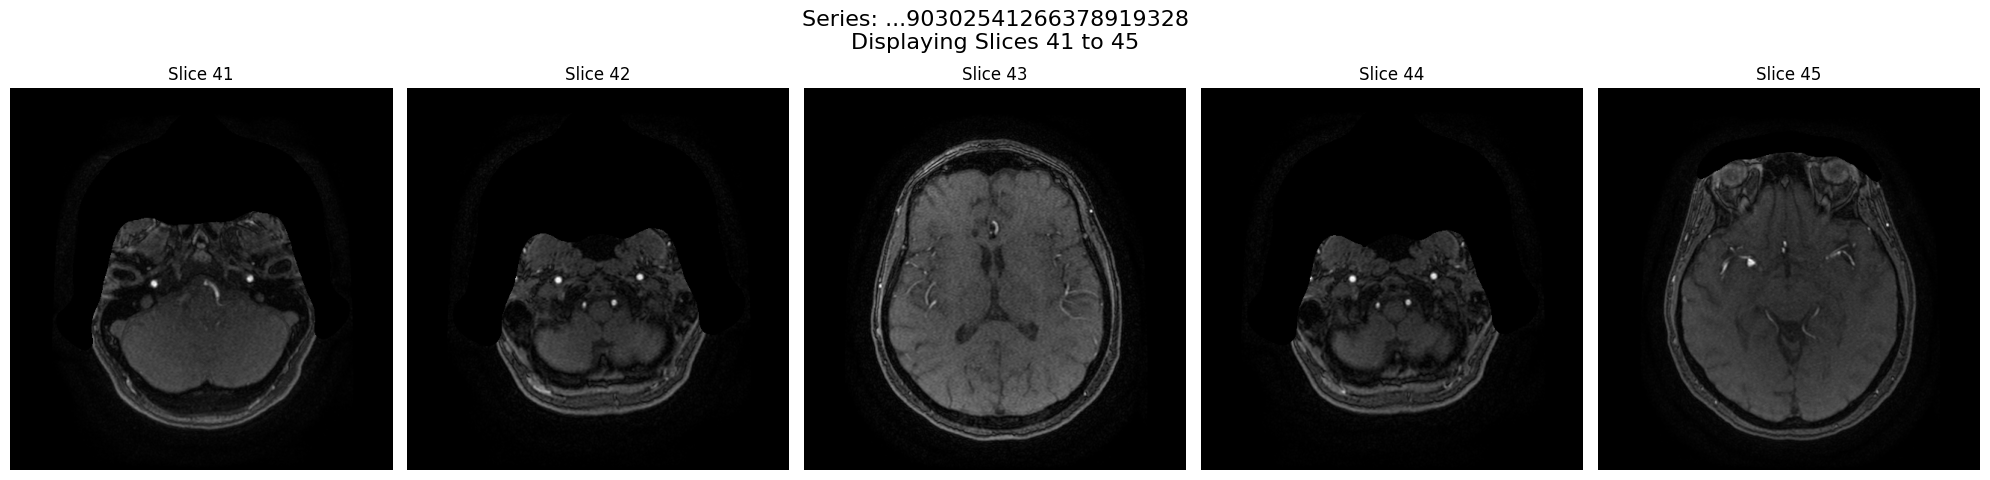

Visualization complete.


In [7]:
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt

# --- Configuration ---
BASE_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/'
TARGET_REGION_COLUMN = 'Left Supraclinoid Internal Carotid Artery'
IDEAL_RATIO = 0.48
IMAGES_TO_SHOW = 10
WINDOW_SIZE = 2 # 2 frames before and 2 after the center frame (total of 5)

# --- 1. Identify "Normal" MRA Scans ---
print(f"Finding 'normal' MRA scans for the region: {TARGET_REGION_COLUMN}...")
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))

normal_scans_df = train_df[
    (train_df['Modality'] == 'MRA') &
    (train_df[TARGET_REGION_COLUMN] == 0)
]
normal_series_ids = normal_scans_df['SeriesInstanceUID'].unique()
print(f"Found {len(normal_series_ids)} 'normal' MRA series for this region.\n")

# --- 2. Visualize a Window of Slices from 10 Normal Scans ---
print(f"Visualizing a {2 * WINDOW_SIZE + 1}-frame window around the {IDEAL_RATIO:.0%} position...")
print("="*60)

visualized_count = 0
for series_uid in normal_series_ids:
    if visualized_count >= IMAGES_TO_SHOW:
        break

    directory_path = os.path.join(BASE_PATH, 'series', series_uid)
    
    try:
        all_files = sorted(os.listdir(directory_path))
        total_frames = len(all_files)
        
        if total_frames <= WINDOW_SIZE:
            continue # Skip series that are too short

        # Calculate the center index
        center_index = int(total_frames * IDEAL_RATIO)

        # Define the window, ensuring it doesn't go out of bounds
        start_index = max(0, center_index - WINDOW_SIZE)
        end_index = min(total_frames - 1, center_index + WINDOW_SIZE)
        
        # Adjust for the actual number of frames we will plot
        num_to_plot = end_index - start_index + 1

        # Create subplots to show the frames in a row
        fig, axes = plt.subplots(1, num_to_plot, figsize=(20, 5))
        fig.suptitle(f"Series: ...{series_uid[-20:]}\nDisplaying Slices {start_index + 1} to {end_index + 1}", fontsize=16)

        for i, slice_idx in enumerate(range(start_index, end_index + 1)):
            file_path = os.path.join(directory_path, all_files[slice_idx])
            dicom_image = pydicom.dcmread(file_path)
            
            # Determine which subplot to use
            ax = axes[i] if num_to_plot > 1 else axes
            
            ax.imshow(dicom_image.pixel_array, cmap=plt.cm.gray)
            ax.set_title(f"Slice {slice_idx + 1}")
            ax.axis('off')
            
            # Highlight the center frame
            if slice_idx == center_index:
                ax.spines['bottom'].set_color('red')
                ax.spines['top'].set_color('red')
                ax.spines['right'].set_color('red')
                ax.spines['left'].set_color('red')

        plt.tight_layout()
        plt.show()
        
        visualized_count += 1
        
    except FileNotFoundError:
        continue 
    except Exception as e:
        print(f"Could not process series {series_uid}: {e}")

print("="*60)
print("Visualization complete.")

In [ ]:
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt
import ast
import numpy as np
from PIL import Image
import shutil

# --- Configuration ---
BASE_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/'
TARGET_REGION_COLUMN = 'Left Supraclinoid Internal Carotid Artery'
IDEAL_RATIO = 0.48
OUTPUT_DIR = '/kaggle/working/dataset/'

# --- 1. Install necessary libraries ---
!pip install -q pydicom-pylibjpeg pillow

# --- 2. Setup Directories ---
# Create the main dataset directory and the class subdirectories
ANEURYSM_DIR = os.path.join(OUTPUT_DIR, 'aneurysm')
NORMAL_DIR = os.path.join(OUTPUT_DIR, 'normal')

# Clean up previous runs if they exist
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

os.makedirs(ANEURYSM_DIR)
os.makedirs(NORMAL_DIR)
print(f"Created directories:\n{ANEURYSM_DIR}\n{NORMAL_DIR}\n")

# --- 3. Image Processing Function ---
def save_dicom_as_png(dicom_path, output_path):
    """Reads a DICOM file, normalizes its pixel data, and saves it as a PNG."""
    try:
        dicom = pydicom.dcmread(dicom_path)
        pixel_array = dicom.pixel_array

        # Normalize the pixel values to the 0-255 range (for 8-bit PNG)
        pixel_array = pixel_array.astype(float)
        pixel_array = (np.maximum(pixel_array, 0) / pixel_array.max()) * 255.0
        pixel_array = np.uint8(pixel_array)

        # Create an image from the array and save it
        img = Image.fromarray(pixel_array)
        img.save(output_path)
        return True
    except Exception as e:
        # print(f"  - Failed to process {os.path.basename(dicom_path)}: {e}")
        return False

# --- 4. Get Aneurysm and Normal Series Lists ---
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
localizers_df = pd.read_csv(os.path.join(BASE_PATH, 'train_localizers.csv'))

# Get all aneurysm cases for the target region
aneurysm_cases_df = localizers_df[
    (localizers_df['location'] == TARGET_REGION_COLUMN) &
    (localizers_df['SeriesInstanceUID'].isin(train_df[train_df['Modality'] == 'MRA']['SeriesInstanceUID']))
]
num_aneurysm_cases = len(aneurysm_cases_df)
print(f"Found {num_aneurysm_cases} aneurysm cases to collect.")

# Get all normal cases for the target region
normal_scans_df = train_df[
    (train_df['Modality'] == 'MRA') &
    (train_df[TARGET_REGION_COLUMN] == 0)
]
# Sample an equal number of normal cases to create a balanced dataset
normal_cases_df = normal_scans_df.sample(n=num_aneurysm_cases, random_state=42)
print(f"Found and sampled {len(normal_cases_df)} normal cases to collect.\n")


# --- 5. Process and Save ANEURYSM Images ---
print("--- Processing Aneurysm Images ---")
aneurysm_saved_count = 0
for index, row in aneurysm_cases_df.iterrows():
    series_uid = row['SeriesInstanceUID']
    sop_uid = row['SOPInstanceUID']
    file_path = os.path.join(BASE_PATH, 'series', series_uid, f'{sop_uid}.dcm')
    output_filepath = os.path.join(ANEURYSM_DIR, f'{sop_uid}.png')
    
    if os.path.exists(file_path):
        if save_dicom_as_png(file_path, output_filepath):
            aneurysm_saved_count += 1
print(f"-> Saved {aneurysm_saved_count} aneurysm images.")


# --- 6. Process and Save NORMAL Images ---
print("\n--- Processing Normal Images ---")
normal_saved_count = 0
for index, row in normal_cases_df.iterrows():
    series_uid = row['SeriesInstanceUID']
    directory_path = os.path.join(BASE_PATH, 'series', series_uid)
    
    try:
        all_files = sorted(os.listdir(directory_path))
        total_frames = len(all_files)
        if total_frames > 0:
            target_index = int(total_frames * IDEAL_RATIO)
            target_filename = all_files[target_index]
            file_path = os.path.join(directory_path, target_filename)
            output_filepath = os.path.join(NORMAL_DIR, f'{os.path.splitext(target_filename)[0]}.png')
            
            if save_dicom_as_png(file_path, output_filepath):
                normal_saved_count += 1
    except FileNotFoundError:
        continue
print(f"-> Saved {normal_saved_count} normal images.")

# --- 7. Final Summary ---
print("\n" + "="*60)
print("Dataset Creation Complete!")
print(f"Total aneurysm images: {len(os.listdir(ANEURYSM_DIR))}")
print(f"Total normal images: {len(os.listdir(NORMAL_DIR))}")
print(f"Your dataset is ready in the '{OUTPUT_DIR}' directory.")

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. Setup and Data Loading ---
print("TensorFlow Version:", tf.__version__)

# Define constants
DATA_DIR = '/kaggle/working/dataset/'
IMAGE_SIZE = (160, 160) # MobileNetV2 was trained on this size
BATCH_SIZE = 16 # How many images to process at once

# Create TensorFlow datasets from the image directories
# This will automatically infer labels from folder names ('aneurysm', 'normal')
# We'll use 80% of the data for training and 20% for validation.
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="both",
    seed=42, # for reproducibility
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Get class names
class_names = train_ds.class_names
print("\nClass Names:", class_names)
print("The model will be trained to predict a score for 'aneurysm' (class 0) vs 'normal' (class 1).")


# --- 2. Configure Datasets for Performance ---
# Use buffered prefetching to load data without I/O becoming a bottleneck.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# --- 3. Build the Model ---

# MobileNetV2 expects pixel values in the [-1, 1] range.
# We create a preprocessing layer to handle this.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Load the pre-trained MobileNetV2 model without its top classification layer.
# We will use weights from 'imagenet', a massive dataset of general images.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)

# FREEZE the base model. This is the key step for feature extraction.
# The weights of these layers will not be updated during training.
base_model.trainable = False

# Create our new classification head to place on top of the frozen base
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1) # Single neuron for binary output

# Chain all the parts together using the Keras Functional API
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs) # Preprocess the input
x = base_model(x, training=False) # Run the base model in inference mode
x = global_average_layer(x) # Pool the features
x = tf.keras.layers.Dropout(0.2)(x) # Add dropout for regularization
outputs = prediction_layer(x) # Get the final prediction
model = tf.keras.Model(inputs, outputs)

print("\nModel architecture is built.")

# --- 4. Compile the Model ---
# We use a low learning rate and BinaryCrossentropy for our two-class problem
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


# --- 5. Train the Model ---
print("\nStarting model training...")
initial_epochs = 15
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds
)


# --- 6. Visualize Training Results ---

# The history object from your completed training is still in memory.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] # FIX: Changed from 'validation_accuracy'
loss = history.history['loss']
val_loss = history.history['val_loss']     # FIX: Changed from 'validation_loss' (just in case)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.suptitle('Method 1: Feature Extraction Training Results')
plt.show()

In [ ]:
# --- 1. Unfreeze the Top Layers of the Base Model ---
base_model.trainable = True

# Let's see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# We'll freeze the first 100 layers and fine-tune the rest.
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"\nUnfroze the top layers. The first {fine_tune_at} layers are frozen.")


# --- 2. Re-compile the Model with a Lower Learning Rate ---
# It's crucial to use a very low learning rate to avoid destroying the pre-trained weights.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


# --- 3. Continue Training the Model ---
print("\nStarting fine-tuning...")
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

# We continue training from where we left off
history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds
)


# --- 4. Visualize the Combined Training Results ---
# Append the fine-tuning history to the initial history
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Add a vertical line to show where fine-tuning started
plt.axvline(initial_epochs -1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.ylim([0.5, 1.05])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# Add a vertical line to show where fine-tuning started
plt.axvline(initial_epochs-1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.suptitle('Method 2: Fine-Tuning Training Results')
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. Setup and Data Loading ---
DATA_DIR = '/kaggle/working/dataset/'
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 16

# Create the datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- 2. Create the Data Augmentation Layer ---
# This layer will apply random transformations to our training images on-the-fly
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# --- 3. Build the Model (with Augmentation) ---
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                             include_top=False,
                                             weights='imagenet')
base_model.trainable = False # Start with the base model frozen

# Chain everything together
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs) # Apply augmentation first!
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

# --- 4. Initial Training (like Method 1) ---
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

print("--- Starting Initial Training with Data Augmentation ---")
initial_epochs = 15
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

# --- 5. Fine-Tuning (like Method 2) ---
base_model.trainable = True # Unfreeze the base model
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

print("\n--- Starting Fine-Tuning with Data Augmentation ---")
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

# --- 6. Visualize Final Results ---
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.ylim([0.5, 1.05])
plt.legend(loc='lower right')
plt.title('Accuracy with Data Augmentation')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Loss with Data Augmentation')
plt.xlabel('Epoch')
plt.suptitle('Method 3: Fine-Tuning with Data Augmentation Results')
plt.show()

In [ ]:
# The '-r' flag means "recursive" to include all subdirectories.
# The '-q' flag makes the output "quiet" to keep the notebook clean.
!zip -r -q dataset.zip /kaggle/working/dataset/

print("Successfully created dataset.zip. You can now download it.")

ERROR: Could not find a version that satisfies the requirement pydicom-pylibjpeg (from versions: none)
ERROR: No matching distribution found for pydicom-pylibjpeg
Created directories:
/kaggle/working/dataset/aneurysm
/kaggle/working/dataset/normal

--- Creating PNG Dataset ---
Dataset creation complete: 109 aneurysm, 106 normal.

--- Loading and Splitting Data ---
Found 215 files belonging to 2 classes.
Data split: 129 train, 43 validation, 43 test.

--- Building Model (Method 3) ---
--- Starting Initial Training ---
Epoch 1/15
9/9 - 18s - 2s/step - accuracy: 0.4961 - loss: 1.0399 - val_accuracy: 0.4651 - val_loss: 1.0359
Epoch 2/15
9/9 - 5s - 543ms/step - accuracy: 0.4961 - loss: 0.9764 - val_accuracy: 0.4651 - val_loss: 0.9336
Epoch 3/15
9/9 - 5s - 582ms/step - accuracy: 0.4574 - loss: 0.9302 - val_accuracy: 0.4651 - val_loss: 0.8542
Epoch 4/15
9/9 - 5s - 553ms/step - accuracy: 0.5039 - loss: 0.8699 - val_accuracy: 0.4884 - val_loss: 0.7974
Epoch 5/15
9/9 - 3s - 324ms/step - accuracy

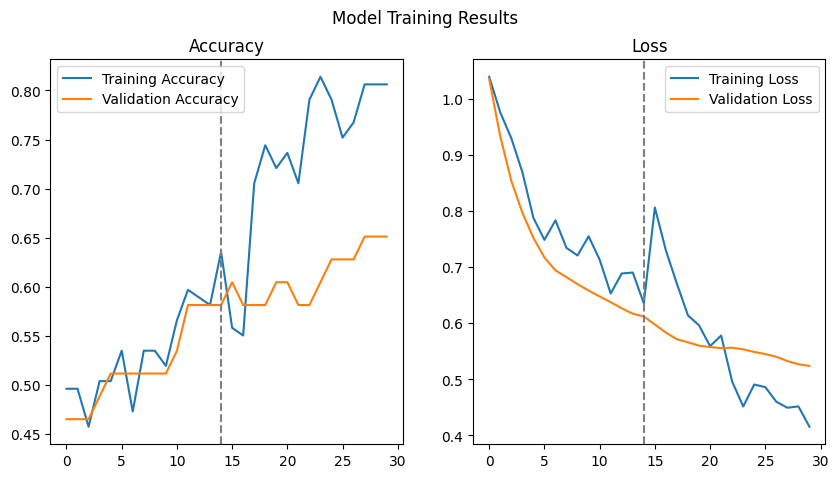


--- Final Model Evaluation on Unseen Test Data ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8016 - loss: 0.4498
Test Loss: 0.4741
Test Accuracy: 0.7907

Classification Report:
              precision    recall  f1-score   support

    aneurysm       0.74      1.00      0.85        25
      normal       1.00      0.50      0.67        18

    accuracy                           0.79        43
   macro avg       0.87      0.75      0.76        43
weighted avg       0.85      0.79      0.77        43



In [4]:
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt
import ast
import numpy as np
from PIL import Image
import shutil
import tensorflow as tf
from sklearn.metrics import classification_report

# --- 0. Install Dependencies ---
# (We know pydicom-pylibjpeg fails, but this is fine for this dataset)
!pip install -q pydicom-pylibjpeg pillow

# --- 1. Define Constants and Setup Directories ---
BASE_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/'
TARGET_REGION_COLUMN = 'Left Supraclinoid Internal Carotid Artery'
IDEAL_RATIO = 0.48
OUTPUT_DIR = '/kaggle/working/dataset/'
ANEURYSM_DIR = os.path.join(OUTPUT_DIR, 'aneurysm')
NORMAL_DIR = os.path.join(OUTPUT_DIR, 'normal')
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 16

# Clean up previous runs if they exist
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(ANEURYSM_DIR)
os.makedirs(NORMAL_DIR)
print(f"Created directories:\n{ANEURYSM_DIR}\n{NORMAL_DIR}\n")

# --- 2. Helper Function to Save Images ---
def save_dicom_as_png(dicom_path, output_path):
    """Reads a DICOM, normalizes it, and saves as PNG."""
    try:
        dicom = pydicom.dcmread(dicom_path)
        pixel_array = dicom.pixel_array
        pixel_array = pixel_array.astype(float)
        pixel_array = (np.maximum(pixel_array, 0) / pixel_array.max()) * 255.0
        pixel_array = np.uint8(pixel_array)
        Image.fromarray(pixel_array).save(output_path)
        return True
    except Exception as e:
        return False

# --- 3. Create the Dataset (PNGs on Disk) ---
print("--- Creating PNG Dataset ---")
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
localizers_df = pd.read_csv(os.path.join(BASE_PATH, 'train_localizers.csv'))

# Get all aneurysm cases for the target region
aneurysm_cases_df = localizers_df[
    (localizers_df['location'] == TARGET_REGION_COLUMN) &
    (localizers_df['SeriesInstanceUID'].isin(train_df[train_df['Modality'] == 'MRA']['SeriesInstanceUID']))
]
num_aneurysm_cases = len(aneurysm_cases_df)

# Get all normal cases for the target region and sample an equal number
normal_scans_df = train_df[
    (train_df['Modality'] == 'MRA') &
    (train_df[TARGET_REGION_COLUMN] == 0)
]
normal_cases_df = normal_scans_df.sample(n=num_aneurysm_cases, random_state=42)

# Process and Save Aneurysm Images
aneurysm_saved_count = 0
for index, row in aneurysm_cases_df.iterrows():
    series_uid = row['SeriesInstanceUID']
    sop_uid = row['SOPInstanceUID']
    file_path = os.path.join(BASE_PATH, 'series', series_uid, f'{sop_uid}.dcm')
    output_filepath = os.path.join(ANEURYSM_DIR, f'{sop_uid}.png')
    if os.path.exists(file_path):
        if save_dicom_as_png(file_path, output_filepath):
            aneurysm_saved_count += 1

# Process and Save Normal Images
normal_saved_count = 0
for index, row in normal_cases_df.iterrows():
    series_uid = row['SeriesInstanceUID']
    directory_path = os.path.join(BASE_PATH, 'series', series_uid)
    try:
        all_files = sorted(os.listdir(directory_path))
        if all_files:
            target_index = int(len(all_files) * IDEAL_RATIO)
            target_filename = all_files[target_index]
            file_path = os.path.join(directory_path, target_filename)
            output_filepath = os.path.join(NORMAL_DIR, f'{os.path.splitext(target_filename)[0]}.png')
            if save_dicom_as_png(file_path, output_filepath):
                normal_saved_count += 1
    except FileNotFoundError:
        continue
print(f"Dataset creation complete: {aneurysm_saved_count} aneurysm, {normal_saved_count} normal.\n")


# --- 4. Load and Split Data (Train/Val/Test) ---
# FIX: This block is rewritten to correctly handle shuffling and splitting
# to prevent data misalignment during evaluation.
print("--- Loading and Splitting Data ---")

# Load the full dataset (unbatched)
# Set shuffle=False to load data in a stable order (aneurysm, then normal)
full_ds = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_DIR,
    image_size=IMAGE_SIZE,
    batch_size=None, # Load as individual images
    label_mode='int',
    shuffle=False, # <-- IMPORTANT FIX
    seed=42
)
class_names = ['aneurysm', 'normal']

# Get the total size
DATA_SIZE = tf.data.experimental.cardinality(full_ds).numpy()
train_size = int(0.6 * DATA_SIZE)
val_size = int(0.2 * DATA_SIZE)
test_size = DATA_SIZE - train_size - val_size

# --- This is the new, correct way to split ---

# 1. Shuffle the full dataset ONCE to randomize it
# We set reshuffle_each_iteration=False so the splits are stable
full_ds = full_ds.shuffle(DATA_SIZE, seed=42, reshuffle_each_iteration=False)

# 2. Create the stable splits
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

# 3. Apply batching, prefetching, and *only* shuffle the train_ds
AUTOTUNE = tf.data.AUTOTUNE

# We add shuffle() here so only the training data is shuffled each epoch
train_ds = train_ds.shuffle(buffer_size=train_size, reshuffle_each_iteration=True)
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

# No shuffle for validation or test data
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

print(f"Data split: {train_size} train, {val_size} validation, {test_size} test.\n")


# --- 5. Build Model (Method 3) ---
print("--- Building Model (Method 3) ---")
# IMPROVEMENT: Added more augmentation to fight overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),  # <-- NEW
    tf.keras.layers.RandomBrightness(0.1), # <-- NEW
], name="data_augmentation")

# Pre-trained base
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                             include_top=False,
                                             weights='imagenet')
base_model.trainable = False

# Chain the model together
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x) # Logits output
model = tf.keras.Model(inputs, outputs)

# --- 6. Initial Training ---
print("--- Starting Initial Training ---")

# IMPROVEMENT: Add EarlyStopping to prevent overfitting
# This will stop training if 'val_loss' doesn't improve for 5 epochs
# It will also restore the model weights from the *best* epoch
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

base_learning_rate = 0.0001
initial_epochs = 15
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    verbose=2, # Set to 2 to see epoch progress
                    callbacks=[early_stopping_callback] # <-- ADDED
                   )
print("Initial training complete.")

# --- 7. Fine-Tuning ---
print("--- Starting Fine-Tuning ---")
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# IMPROVEMENT: Add EarlyStopping for the fine-tuning phase
early_stopping_fine_tune = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

fine_tune_epochs = 15
# FIX: The total number of epochs is the *target*
# The initial_epoch is where it *starts*
total_epochs = initial_epochs + fine_tune_epochs

# FIX: Find the last epoch that *actually* ran
# history.epoch[-1] is the index (e.g., 14), so the next epoch is + 1
last_epoch = history.epoch[-1]

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=last_epoch + 1, # <-- FIX: Start from the *next* epoch
                         validation_data=val_ds,
                         verbose=2, # Set to 2 to see epoch progress
                         callbacks=[early_stopping_fine_tune] # <-- ADDED
                        )
print("Fine-tuning complete.\n")

# --- 8. Visualize Training ---
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# FIX: Calculate the dividing line based on how many epochs *actually* ran
initial_epochs_run = len(history.history['loss'])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs_run - 1, color='gray', linestyle='--')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs_run - 1, color='gray', linestyle='--')
plt.title('Loss')
plt.legend()
plt.suptitle('Model Training Results')
plt.show()

# --- 9. Final Evaluation on Test Set ---
# FIX: This block is rewritten to correctly get aligned labels and predictions.
print("\n" + "="*60)
print("--- Final Model Evaluation on Unseen Test Data ---")

# This is the most reliable, single metric for your model's performance
# It will now be consistent with the report below.
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get detailed metrics
print("\n" + "="*60)
print("Classification Report:")

# Get true labels and predictions in ONE pass to guarantee alignment
y_true = []
y_pred_logits = []

# Iterate through the test set *once*
# This dataset is NOT shuffled, so this is stable.
for images, labels in test_ds:
    preds = model(images, training=False) # Get model predictions (logits)
    y_true.extend(labels.numpy())
    y_pred_logits.extend(preds.numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_logits = np.array(y_pred_logits)

# Apply sigmoid and threshold (0.5) to convert logits to class labels (0 or 1)
y_pred_probs = tf.nn.sigmoid(y_pred_logits).numpy()
y_pred = np.where(y_pred_probs > 0.5, 1, 0).flatten() # flatten to match y_true shape

# Now y_true and y_pred are perfectly aligned
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)

--- Testing a New Image ---
Loading and predicting for: /kaggle/input/dataset1/data/a3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


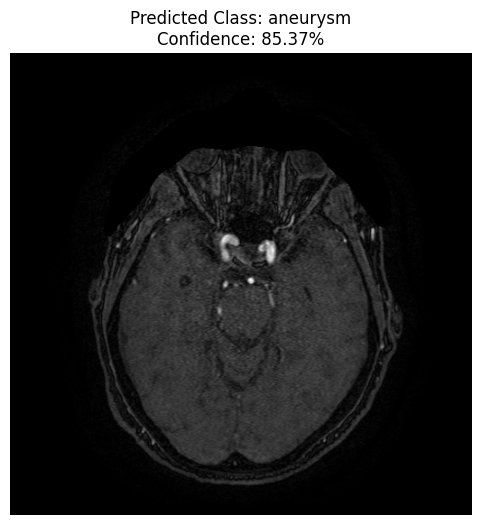

In [7]:
# --- 10. Test a New Image (Reliable Method) ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("--- Testing a New Image ---")

# --- 1. Specify Your Image Path ---
#
# IMPORTANT: Follow the steps above to drag-and-drop your
# test PNG file into the "/kaggle/working/" directory.
#
# Then, update the path below to match the name of the
# file you just uploaded.
#
# !! ----- UPDATE THIS LINE ----- !!
TEST_IMAGE_PATH = '/kaggle/input/dataset1/data/a3.png' 
# !! ---------------------------- !!


# --- 2. Load and Preprocess the Image ---
try:
    # Load the image using Keras utilities
    img = tf.keras.utils.load_img(
        TEST_IMAGE_PATH, 
        target_size=IMAGE_SIZE,  # This variable (160, 160) is from Step 1
        color_mode='rgb'
    )
    
    # Convert the image to a numpy array
    img_array = tf.keras.utils.img_to_array(img)
    
    # Create a batch
    img_batch = tf.expand_dims(img_array, 0) 

    # --- 3. Make Prediction ---
    print(f"Loading and predicting for: {TEST_IMAGE_PATH}")
    prediction_logits = model.predict(img_batch)
    
    # Your model outputs logits (a raw number). We pass it through a sigmoid
    prediction_prob = tf.nn.sigmoid(prediction_logits[0])[0].numpy()
    
    # Your class_names = ['aneurysm', 'normal'] (from Step 4)
    if prediction_prob > 0.5:
        predicted_class_index = 1 # Normal
        confidence = prediction_prob
    else:
        predicted_class_index = 0 # Aneurysm
        confidence = 1 - prediction_prob
        
    predicted_label = class_names[predicted_class_index]
    
    # --- 4. Display Results ---
    plt.figure(figsize=(6, 6))
    
    display_img = plt.imread(TEST_IMAGE_PATH)
    plt.imshow(display_img, cmap='gray') # Use 'gray' colormap for MRA scans
    plt.axis('off')
    
    title = f"Predicted Class: {predicted_label}\nConfidence: {confidence * 100:.2f}%"
    plt.title(title)
    plt.show()

except FileNotFoundError:
    print(f"Error: File not found at '{TEST_IMAGE_PATH}'")
    print("Please make sure you have uploaded the file to /kaggle/working/")
    print("and that the filename matches exactly.")
except Exception as e:
    print(f"An error occurred: {e}")